In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pickle
import os
from IPython.display import display as print

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


import importlib


In [2]:
import core_lib
importlib.reload(core_lib)

from core_lib import plot_dataset,r2_loss,get_predict_ks, get_dcdt_func_for_sunode
from core_lib import get_predict_starts
from core_lib import get_model, get_model2, distance_func, MY_EPSILON
from core_lib import MyDataset


In [3]:
db_csv_path = "dataset/data.csv"

# 忽略部分数据的结果，但是忽略的数据正常
# idata_save_path = "runtime/pts/research-fake-data-success.dt"

# 忽略部分数据的结果，但是忽略的数据不正常
idata_save_path = "runtime/pts/research-fake-data-randome-fake-success-v3.dt"

# dataset_ori = core_lib.MyDataset(db_csv_path)
# df_ori = dataset_ori.get_df()
# cct_names, rates_names, error_names = dataset_ori.get_var_col_names()
# c0 = df_ori[cct_names].iloc[0].values


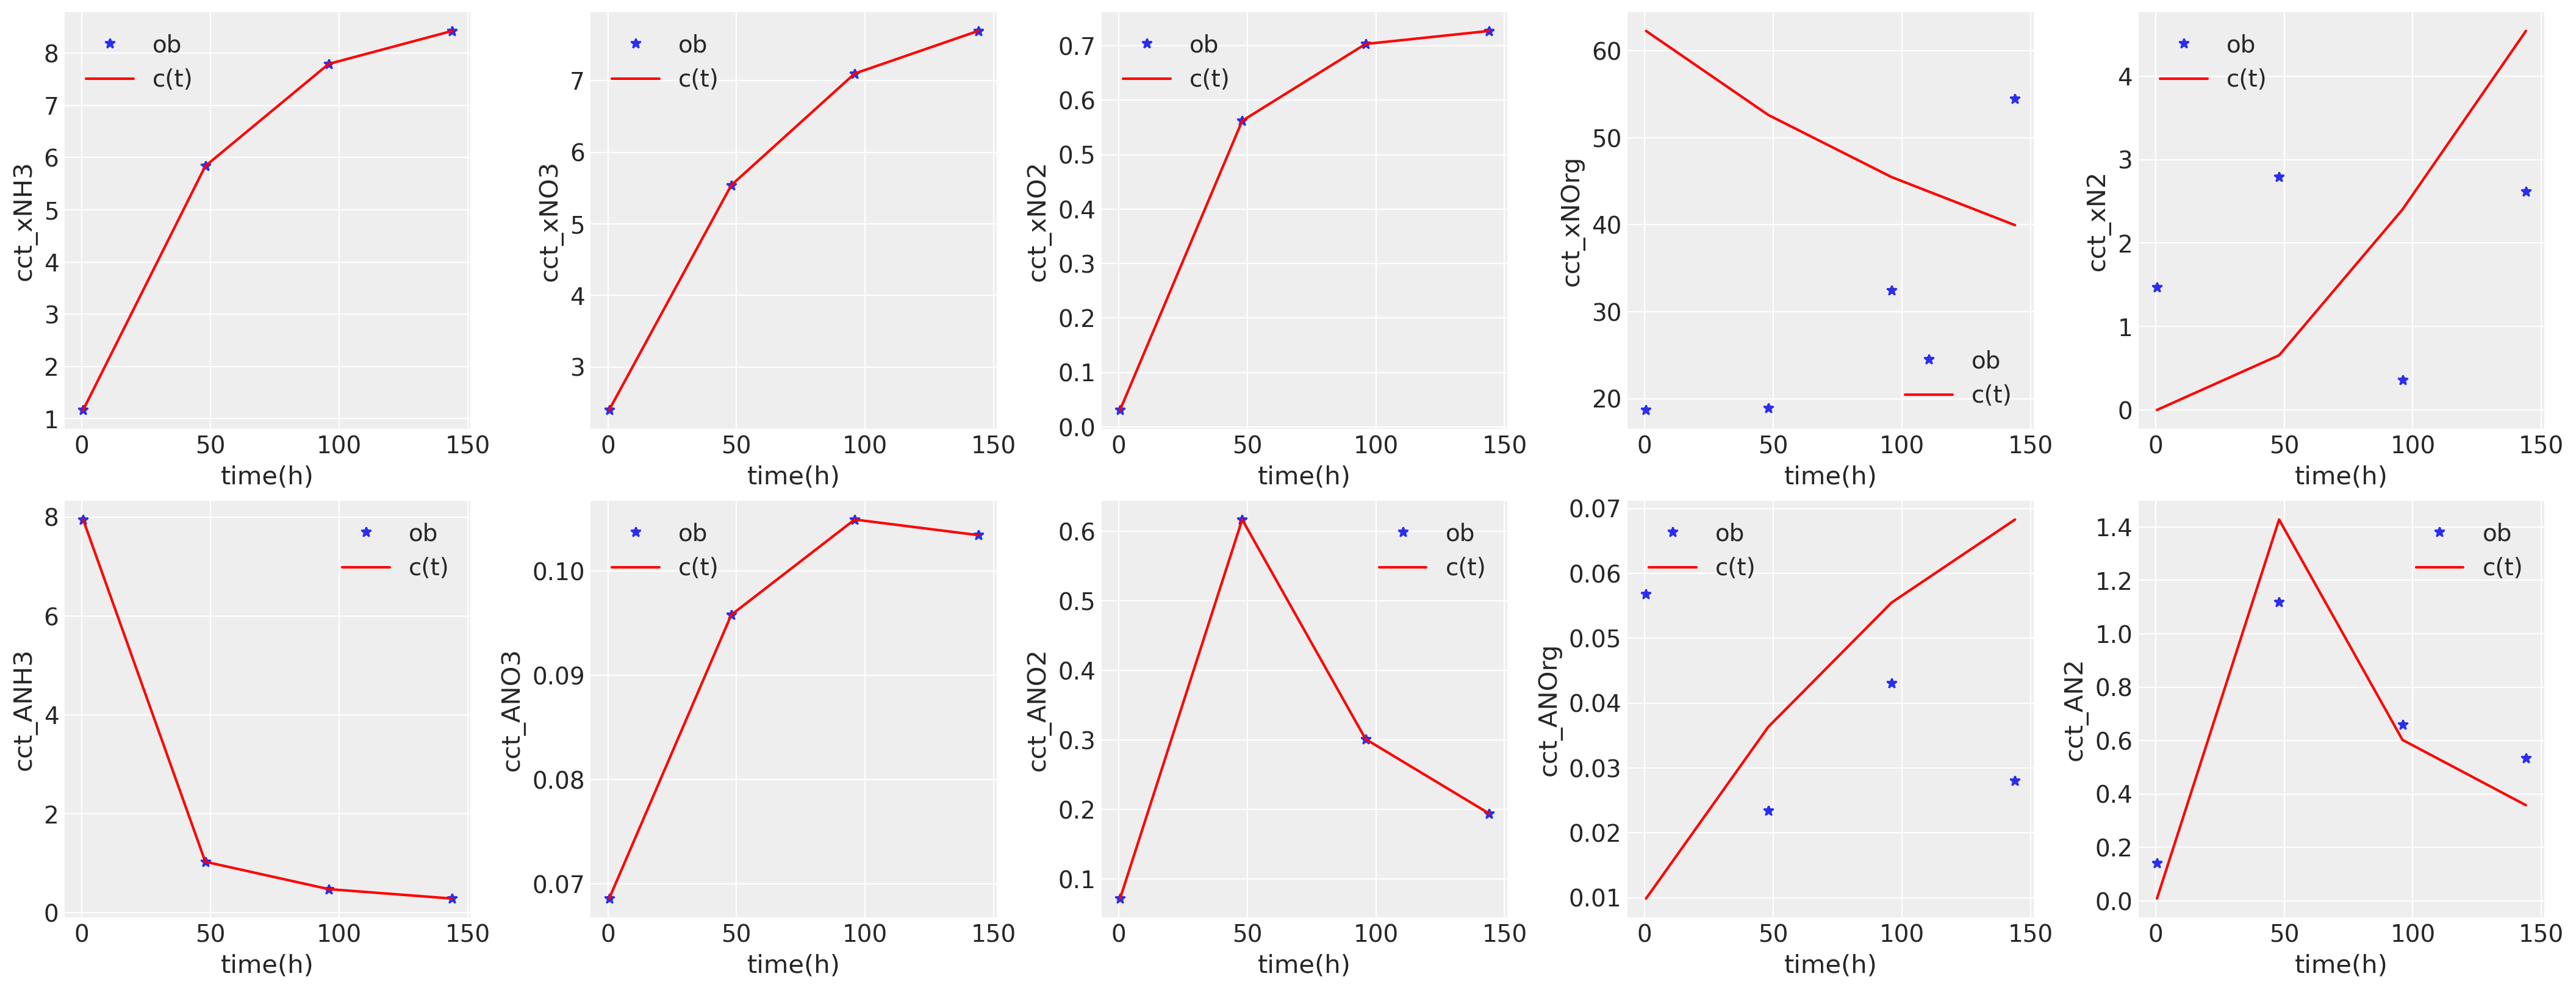

In [4]:
# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8)
# k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8)
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================
import copy

# t_eval = np.linspace(0, 150, 100)
t_eval = np.array([0.5, 48, 96, 144])

# 初始化原始数据
dataset_ori = core_lib.MyDataset(db_csv_path)

# 初始化正确的模拟数据
dataset_sim = core_lib.MyDataset(db_csv_path)
_cct_names = dataset_sim.get_cct_names()
_c0 = dataset_sim.df[_cct_names].iloc[0].values
dataset_sim.set_as_sim_dataset(t_eval, _c0, t0=0.5, args=(ks, k_kinetics))

# 由模拟数据，生成fake字段
dataset_fake = copy.deepcopy(dataset_sim)
fake_colums = dataset_fake.get_fake_cct_names()
dataset_fake.set_random(c_names=fake_colums)


cct_names, rates_names, error_names = dataset_fake.get_var_col_names()
c0 = dataset_fake.df[cct_names].iloc[0].values
plot_dataset(dataset_fake, dataset_sim)

In [7]:

print(core_lib.MY_EPSILON_TEE_v3)

print(dataset_fake.df[cct_names].iloc[0].values)

[1, 1, 0.01, 100000000.0, 100000000.0, 1, 0.01, 0.01, 100000000.0, 100000000.0]

array([ 1.16666667,  2.39880952,  0.0311    , 18.70563812,  1.47155921,
        7.94863498,  0.06857923,  0.07231   ,  0.05677608,  0.14163501])

In [8]:

# mcmc_model = core_lib.get_model(dataset_sim, t_eval, k_kinetics, distance=core_lib.distance_func_v3, epsilon=core_lib.MY_EPSILON_TEE_v3, k_sigma_priors=0.01, kf_type=0, c0_type=0)
# 
mcmc_model = core_lib.get_model_v4(dataset_sim, t_eval, k_kinetics, distance=core_lib.distance_func_v3, epsilon=core_lib.MY_EPSILON_TEE_v3, k_sigma_priors=0.01, kf_type=0, c0_type=0)

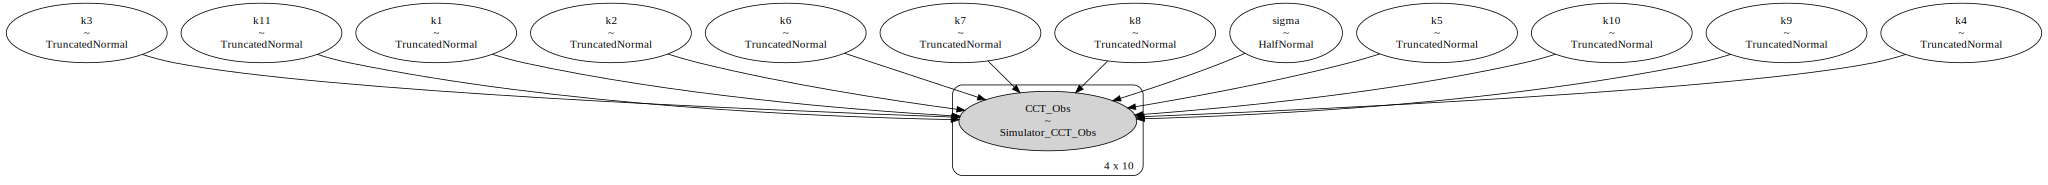

In [9]:
# print(get_format_time(),idata_save_path)
# print(ks, c0)
pm.model_to_graphviz(mcmc_model)

In [10]:
print(idata_save_path)
# idata_lv = pickle.load(open(idata_save_path, 'rb'))

os.makedirs(os.path.dirname(idata_save_path), exist_ok=True)
idata_lv = pm.sample_smc(draws=2000, chains=4, model=mcmc_model, progressbar=True)
pickle.dump(idata_lv,open(idata_save_path, 'wb'))

'runtime/pts/research-fake-data-randome-fake-success-v3.dt'

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/izhangxm/miniconda3/envs/pymcmain/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/izhangxm/miniconda3/envs/pymcmain/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3723741154687D+02   r2 =  0.2905279187917D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3723741154687D+02   r2 =  0.2214534856477D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3723741154687D+02   r2 =  0.1682184464027D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3723741154687D+02   r2 =  0.1272369350561D-14
 lsoda--  warning..internal t (=r1) 

/home/izhangxm/miniconda3/envs/pymcmain/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/izhangxm/miniconda3/envs/pymcmain/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3945423763330D+02   r2 =  0.1410295052552D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3945423763330D+02   r2 =  0.1410295052552D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3945423763330D+02   r2 =  0.3525737631379D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3945423763330D+02   r2 =  0.3525737631379D-15
 lsoda--  warning..internal t (=r1) 

KeyboardInterrupt: 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3983422356658D+02   r2 =  0.3396395237199D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3983422356658D+02   r2 =  0.3396395237199D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3983422356658D+02   r2 =  0.3226650549662D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3983422356658D+02   r2 =  0.8066626374155D-15
 lsoda--  warning..internal t (=r1) 

In [ ]:
# az.plot_trace(idata_lv, kind="rank_vlines");
dataset_fake.df[cct_names]

In [ ]:
print(az.summary(idata_lv, round_to=10))
print(ks)
az.plot_trace(idata_lv, kind="rank_bars")
plt.suptitle(f"Trace Plot");


In [ ]:
ks_predict = get_predict_ks(idata_lv)
s_p = get_predict_starts(cct_names, idata_lv)
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.array([0.5, 48, 96, 144])

dataset_new = MyDataset(db_csv_path)
cct_names, rates_names, error_names = dataset_new.get_var_col_names()
gt_s = dataset_new.get_cct()[0]

dataset_new.set_as_sim_dataset(t_eval, s_p, t0=0.5, args=(ks_predict, k_kinetics))
plot_dataset(dataset_sim, dataset_new)
# print("r2_loss", r2_loss(dataset_new.get_cct(), dataset.get_cct()))


t_eval_new = np.linspace(0.5, 150, 200)
dataset_new2 = MyDataset(db_csv_path)
dataset_new2.set_as_sim_dataset(t_eval_new, s_p, t0=0.5, args=(ks_predict, k_kinetics))
plot_dataset(dataset_sim, dataset_new2)

print(ks_predict)

In [ ]:
plot_dataset(dataset_fake, dataset_new)
plot_dataset(dataset_fake, dataset_new2)

In [ ]:
ks_predict

In [ ]:
# [0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
    #    0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
    #    0.00177611]